In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from gensim.models.word2vec import PathLineSentences, LineSentence, Word2Vec
from pathlib import Path
import networkx as nx
from sklearn import model_selection, linear_model, preprocessing, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
%matplotlib inline


In [2]:
def read_edge_ids(fname):
    d = {}
    with open(fname) as f:
        for line in f:
           (src, dst, e_id) = line.split("\t")
           d[(int(src),int(dst))] = int(e_id)
    return d

In [3]:
def read_probs(fname, e_size):
    t_probs = np.zeros((e_size, e_size))
    with open(fname) as f:
        for line in f:
           (s_id, d_id, p) = line.split("\t")
           t_probs[int(s_id),int(d_id)] = p
    return t_probs

In [17]:
edge_id_file = "/Users/Ganymedian/Desktop/dynamic-rw/output/karate-2nd/edge-id-map.txt"
probs_file = "/Users/Ganymedian/Desktop/dynamic-rw/output/karate-2nd/so-probs.txt"
e_id_map = read_edge_ids(edge_id_file)
e_size = len(e_id_map)
M_theory = read_probs(probs_file, e_size).T


In [18]:
def read_walks(m, v, wl, nw):
    fname = "ar-" + m + "-wl" + str(wl) + "-nw" + str(nw) + "-" + v
    rws = np.concatenate([
        np.loadtxt(f.open(), delimiter='\t', dtype=int)
        for f in rw_location.glob(fname + "-*.txt")
        if f.stat().st_size > 0
    ])
    ars = np.vsplit(rws, 5)
    return ars

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34]
m1
m2
m3
m4


<function matplotlib.pyplot.show>

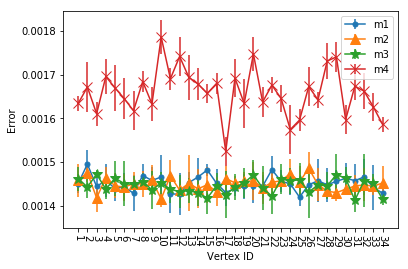

In [19]:
methods = ["m1", "m2", "m3", "m4"]
nmethods = len(methods)
num_runs = 5
wl = 3
nw = 100
rw_location = Path("/Users/Ganymedian/Desktop/dynamic-rw/output/karate-2nd")
formats=['.-', '^-', '*-','x-']
n_nodes = 34
vertices = np.arange(1,n_nodes+1)
print(vertices)

for mm in range(nmethods):
    print(methods[mm])
    all_errors = []
    for vv in vertices:
        v = "v"+str(vv)
        runs = read_walks(methods[mm], v, wl, nw)
        errors = []
        for rr in range(num_runs):
            M_empirical = np.zeros((e_size, e_size))
            for walk in runs[rr]:
                for kk in range(wl): #+2 - 1 because of the second order random walk 
                    s_edge = (walk[kk], walk[kk + 1])
                    d_edge = (walk[kk + 1], walk[kk + 2])
                    s_id = e_id_map.get(s_edge)
                    d_id = e_id_map.get(d_edge)
                    M_empirical[s_id, d_id] += 1

            M_empirical = M_empirical.T / np.maximum(M_empirical.sum(axis=1), 1.0)
            
            errors.append(np.abs(M_theory - M_empirical).mean())

        all_errors.append(errors)

    means = np.mean(all_errors,axis=1)
    stdv = np.std(all_errors, axis=1)
    plt.errorbar(vertices, means, yerr=stdv, fmt=formats[mm], label=methods[mm], ms=10)
    plt.xticks(vertices, rotation=-90)
    plt.legend()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size
plt.xlabel("Vertex ID")
plt.ylabel("Error")
plt.show